In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/chandniagarwal/Gan_Classifier.git

Cloning into 'Gan_Classifier'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 65 (delta 19), reused 60 (delta 14), pack-reused 0
Receiving objects: 100% (65/65), 2.09 MiB | 5.70 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [ ]:
!mkdir training
!cp -r /content/drive/MyDrive/researchwork_15.9.203/training_dataset/recon /content/training/recon
!cp -r /content/drive/MyDrive/researchwork_15.9.203/training_dataset/celebagt /content/training/ground
!cp -r /content/drive/MyDrive/researchwork_15.9.203/testing /content/testing

In [ ]:
import sys
sys.path.append('/content/Gan_Classifier/src')
import glob
import os
import numpy as np
import cv2
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import *
from keras import optimizers


from keras.models import Sequential
from keras.layers import Input, Dense, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

import time
import random
import seaborn as sns
from DatasetCreation import DatasetCreation
from Model import Model
from ElmModel import elm
from numba import cuda

In [ ]:
tf.random.set_seed(
    42
)
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
list_images=[]
labels=[]

In [ ]:
# Testing Data Location
test_gt = "/content/drive/MyDrive/researchwork_15.9.203/testing/gt"
test_gen = "/content/drive/MyDrive/researchwork_15.9.203/testing/gen"
test_ec = "/content/drive/MyDrive/researchwork_15.9.203/testing/ec"
test_vqvae = "/content/drive/MyDrive/researchwork_15.9.203/testing/vqvae"
test_mask = "/content/drive/MyDrive/imageclassificationmodel/dataset/mask2000"
test_unmask = "/content/drive/MyDrive/imageclassificationmodel/dataset/gt2000"

In [ ]:
# test_gt = '/content/drive/MyDrive/imageclassificationmodel/dataset/pixgan20epochs/e3'
# test_vqvae='/content/drive/MyDrive/imageclassificationmodel/dataset/pixgan20epochs/g3'

In [ ]:
# Training Data Location
train_gt='/content/training/ground'
train_recon='/content/training/recon'

In [ ]:
# training Data
image_loc_ground = glob.glob(train_gt+"/*.jpg")
labels = len(image_loc_ground) * ["ground"]
image_loc_recon = glob.glob(train_recon+"/*.jpg")

labels += len(image_loc_recon) * ["recon"]
image_loc = image_loc_ground + image_loc_recon

training_dataset = DatasetCreation(image_loc, labels, "binary")
# for 152 layer
training_dataset_152_layer = DatasetCreation(
    image_loc, labels, "binary", tf.keras.applications.resnet50.preprocess_input
)
print(training_dataset.images.shape)
print(training_dataset.labels.shape)

_________Loading Images__________


100%|██████████| 7178/7178 [00:24<00:00, 295.34it/s]


_________Loading Images__________


100%|██████████| 7178/7178 [00:14<00:00, 486.68it/s]


(7178, 224, 224, 3)
(7178,)


## load model

In [ ]:
def load_model(model_function, layers_to_train):
  start = time.time()
  # load resnet model
  base_model = model_function(
      input_shape=(224,224,3),
      include_top=False,
      weights='imagenet'
  )

  for layer in base_model.layers:
      layer.trainable = False

  for layer in layers_to_train:
    base_model.get_layer(layer).trainable = True


  # Create your binary classification layers on top of the base model
  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Add a global average pooling layer
  x = tf.keras.layers.Dense(1000, activation='relu')(x) # intermediate hidden layer
  x = tf.keras.layers.Dropout(0.2)(x)
  predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Binary classification output layer

  # Combine the base model and your custom layers into a new model
  model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

  print('Running time: %.4f seconds' % (time.time()-start))
  return model

In [ ]:
model_resnet_152_full = load_model(tf.keras.applications.ResNet152, ["conv5_block3_out"])
model_resnet_101_full = load_model(tf.keras.applications.ResNet101, ["conv5_block3_out"])
model_resnet_50_full = load_model(tf.keras.applications.ResNet50, ["conv5_block3_out"])

model_resnet_152_freeze = load_model(tf.keras.applications.ResNet152, [])
model_resnet_101_freeze = load_model(tf.keras.applications.ResNet101, [])
model_resnet_50_freeze = load_model(tf.keras.applications.ResNet50, [])

Running time: 4.6230 seconds
Running time: 3.1581 seconds
Running time: 1.6486 seconds
Running time: 5.1912 seconds
Running time: 3.2216 seconds
Running time: 1.6634 seconds


In [ ]:
model_softmax = {
    "152_full": model_resnet_152_full,
    "101_full": model_resnet_101_full,
    "50_full": model_resnet_50_full,
    "152_freeze": model_resnet_152_freeze,
    "101_freeze": model_resnet_101_freeze,
    "50_freeze": model_resnet_50_freeze,
}
model_data = {
    "152_full": training_dataset_152_layer,
    "101_full": training_dataset,
    "50_full": training_dataset,
    "152_freeze": training_dataset_152_layer,
    "101_freeze": training_dataset,
    "50_freeze": training_dataset,
}

## Resnet Training

__________ 152_full __________________________________________________
Epoch 1/50
90/90 [==============================] - 31s 150ms/step - loss: 0.7741 - accuracy: 0.7025 - val_loss: 1.0411 - val_accuracy: 0.4227 - lr: 0.0010
Epoch 2/50
90/90 [==============================] - 8s 94ms/step - loss: 0.4269 - accuracy: 0.8145 - val_loss: 0.7725 - val_accuracy: 0.5926 - lr: 0.0010
Epoch 3/50
90/90 [==============================] - 8s 94ms/step - loss: 0.3856 - accuracy: 0.8323 - val_loss: 0.5078 - val_accuracy: 0.7326 - lr: 0.0010
Epoch 4/50
90/90 [==============================] - 7s 77ms/step - loss: 0.3481 - accuracy: 0.8501 - val_loss: 0.6334 - val_accuracy: 0.6783 - lr: 0.0010
Epoch 5/50
90/90 [==============================] - 7s 78ms/step - loss: 0.3134 - accuracy: 0.8666 - val_loss: 0.6791 - val_accuracy: 0.6720 - lr: 0.0010
Epoch 6/50
90/90 [==============================] - 7s 77ms/step - loss: 0.2946 - accuracy: 0.8718 - val_loss: 0.5373 - val_accuracy: 0.7361 - lr: 0.0010
Epo

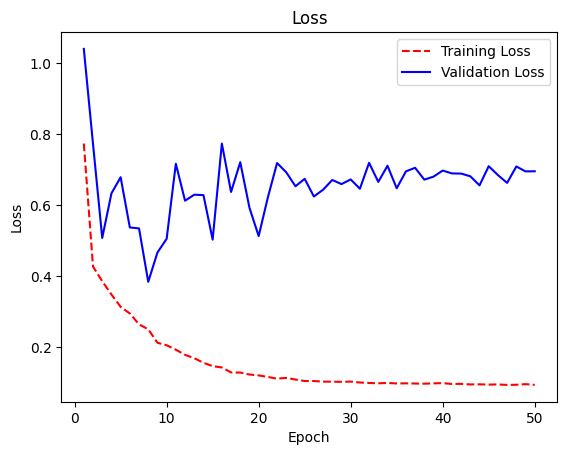

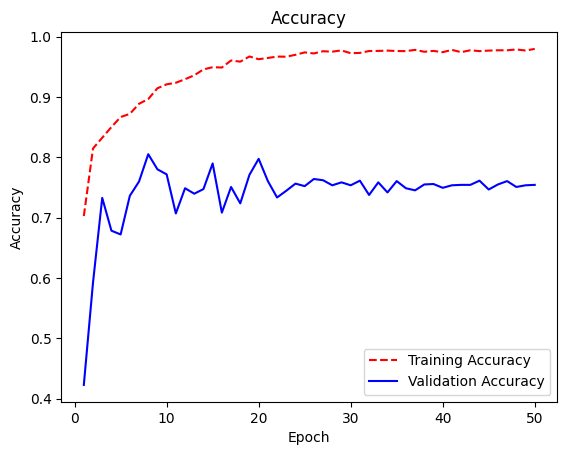

Epoch: 8
loss:0.25
accuracy:0.9
val_loss:0.38
val_accuracy:0.81
lr:0.0
__________ 101_full __________________________________________________
Epoch 1/50
90/90 [==============================] - 16s 106ms/step - loss: 0.7000 - accuracy: 0.5904 - val_loss: 1.2643 - val_accuracy: 0.0014 - lr: 0.0010
Epoch 2/50
90/90 [==============================] - 6s 70ms/step - loss: 0.6594 - accuracy: 0.6207 - val_loss: 0.8528 - val_accuracy: 0.2201 - lr: 0.0010
Epoch 3/50
90/90 [==============================] - 6s 70ms/step - loss: 0.6383 - accuracy: 0.6303 - val_loss: 0.8267 - val_accuracy: 0.3635 - lr: 0.0010
Epoch 4/50
90/90 [==============================] - 5s 60ms/step - loss: 0.6404 - accuracy: 0.6358 - val_loss: 1.0732 - val_accuracy: 0.0682 - lr: 0.0010
Epoch 5/50
90/90 [==============================] - 6s 71ms/step - loss: 0.6312 - accuracy: 0.6449 - val_loss: 0.8141 - val_accuracy: 0.3586 - lr: 0.0010
Epoch 6/50
90/90 [==============================] - 6s 70ms/step - loss: 0.6279 - accu

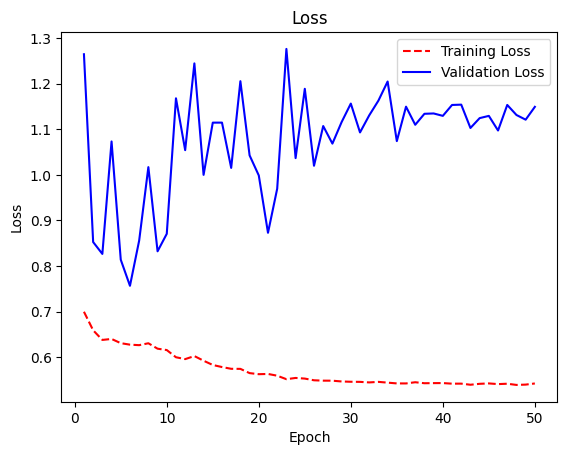

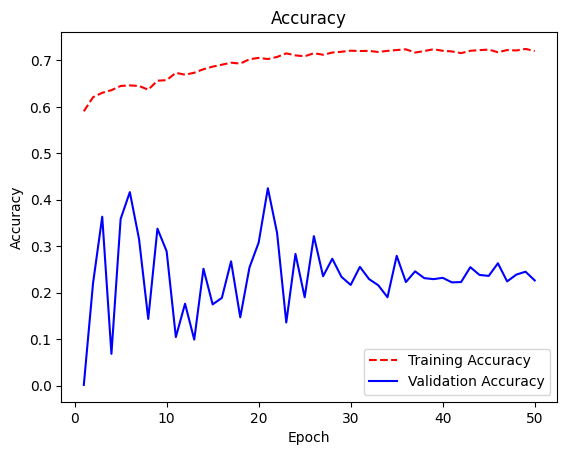

Epoch: 6
loss:0.63
accuracy:0.65
val_loss:0.76
val_accuracy:0.42
lr:0.0
__________ 50_full __________________________________________________
Epoch 1/50
90/90 [==============================] - 11s 79ms/step - loss: 0.7264 - accuracy: 0.5974 - val_loss: 1.1323 - val_accuracy: 0.0216 - lr: 0.0010
Epoch 2/50
90/90 [==============================] - 4s 49ms/step - loss: 0.6551 - accuracy: 0.6183 - val_loss: 0.7944 - val_accuracy: 0.3412 - lr: 0.0010
Epoch 3/50
90/90 [==============================] - 4s 44ms/step - loss: 0.6359 - accuracy: 0.6336 - val_loss: 0.8238 - val_accuracy: 0.3670 - lr: 0.0010
Epoch 4/50
90/90 [==============================] - 4s 44ms/step - loss: 0.6363 - accuracy: 0.6344 - val_loss: 1.0501 - val_accuracy: 0.1462 - lr: 0.0010
Epoch 5/50
90/90 [==============================] - 4s 50ms/step - loss: 0.6294 - accuracy: 0.6421 - val_loss: 0.7539 - val_accuracy: 0.4533 - lr: 0.0010
Epoch 6/50
90/90 [==============================] - 4s 49ms/step - loss: 0.6258 - accur

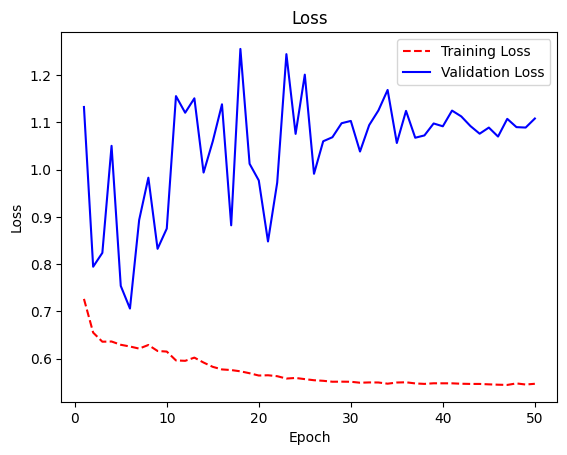

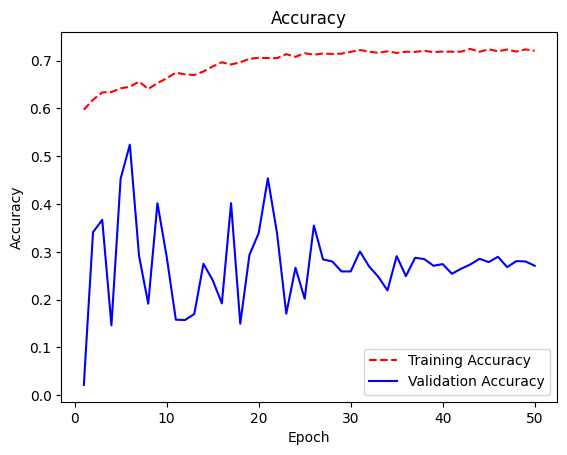

Epoch: 6
loss:0.63
accuracy:0.65
val_loss:0.71
val_accuracy:0.52
lr:0.0
__________ 152_freeze __________________________________________________
Epoch 1/50
90/90 [==============================] - 21s 135ms/step - loss: 0.7078 - accuracy: 0.7123 - val_loss: 0.9238 - val_accuracy: 0.4861 - lr: 0.0010
Epoch 2/50
90/90 [==============================] - 8s 91ms/step - loss: 0.4202 - accuracy: 0.8150 - val_loss: 0.8968 - val_accuracy: 0.5348 - lr: 0.0010
Epoch 3/50
90/90 [==============================] - 8s 93ms/step - loss: 0.3755 - accuracy: 0.8405 - val_loss: 0.4839 - val_accuracy: 0.7451 - lr: 0.0010
Epoch 4/50
90/90 [==============================] - 7s 76ms/step - loss: 0.3451 - accuracy: 0.8518 - val_loss: 0.7528 - val_accuracy: 0.6372 - lr: 0.0010
Epoch 5/50
90/90 [==============================] - 7s 76ms/step - loss: 0.3070 - accuracy: 0.8657 - val_loss: 0.6427 - val_accuracy: 0.6929 - lr: 0.0010
Epoch 6/50
90/90 [==============================] - 7s 76ms/step - loss: 0.2932 - a

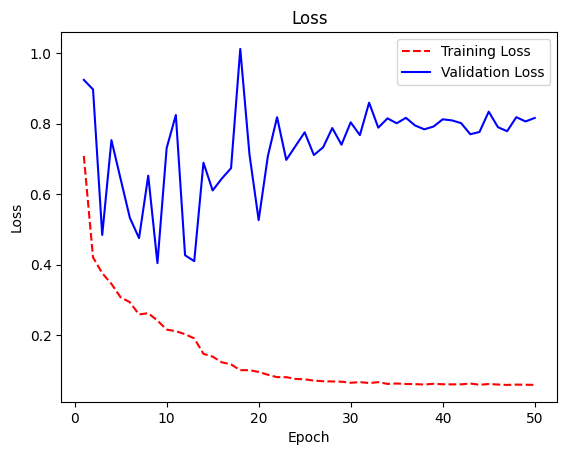

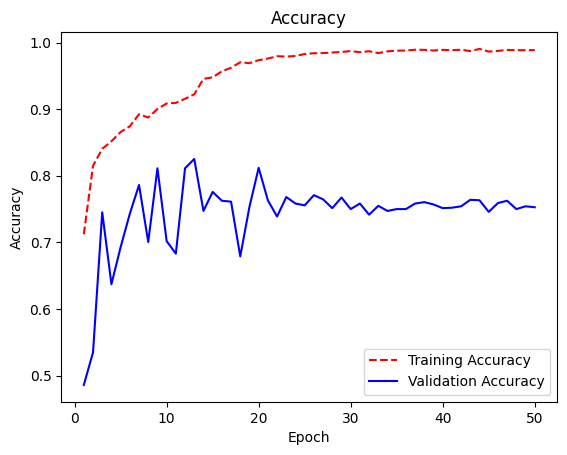

Epoch: 9
loss:0.24
accuracy:0.9
val_loss:0.4
val_accuracy:0.81
lr:0.0
__________ 101_freeze __________________________________________________
Epoch 1/50
90/90 [==============================] - 16s 107ms/step - loss: 0.7191 - accuracy: 0.5892 - val_loss: 1.1128 - val_accuracy: 0.0042 - lr: 0.0010
Epoch 2/50
90/90 [==============================] - 6s 70ms/step - loss: 0.6554 - accuracy: 0.6181 - val_loss: 0.7420 - val_accuracy: 0.4694 - lr: 0.0010
Epoch 3/50
90/90 [==============================] - 5s 59ms/step - loss: 0.6436 - accuracy: 0.6271 - val_loss: 0.8048 - val_accuracy: 0.3628 - lr: 0.0010
Epoch 4/50
90/90 [==============================] - 5s 59ms/step - loss: 0.6391 - accuracy: 0.6322 - val_loss: 1.0939 - val_accuracy: 0.0634 - lr: 0.0010
Epoch 5/50
90/90 [==============================] - 5s 59ms/step - loss: 0.6313 - accuracy: 0.6463 - val_loss: 0.8119 - val_accuracy: 0.3447 - lr: 0.0010
Epoch 6/50
90/90 [==============================] - 5s 58ms/step - loss: 0.6289 - acc

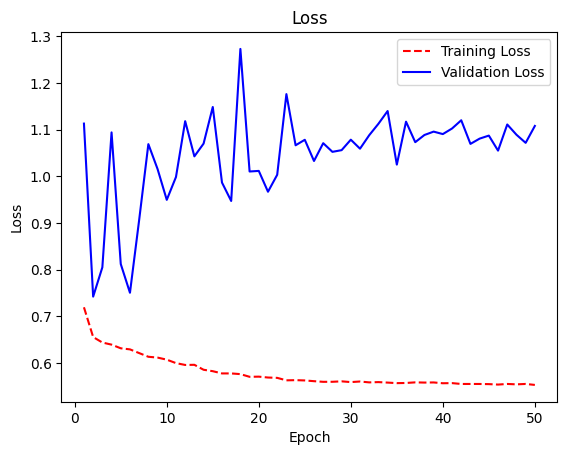

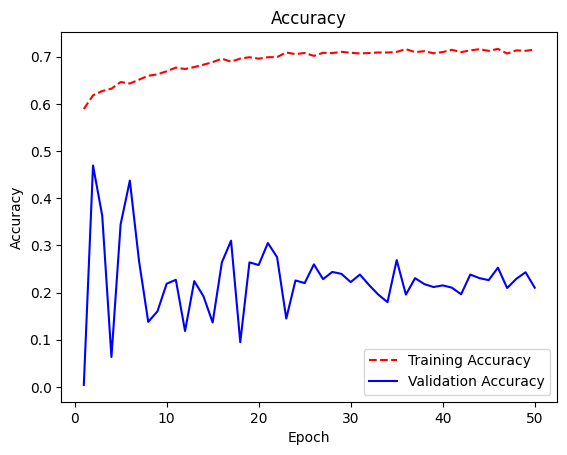

Epoch: 2
loss:0.66
accuracy:0.62
val_loss:0.74
val_accuracy:0.47
lr:0.0
__________ 50_freeze __________________________________________________
Epoch 1/50
90/90 [==============================] - 11s 85ms/step - loss: 0.7242 - accuracy: 0.5979 - val_loss: 0.9777 - val_accuracy: 0.0752 - lr: 0.0010
Epoch 2/50
90/90 [==============================] - 4s 49ms/step - loss: 0.6486 - accuracy: 0.6277 - val_loss: 0.7892 - val_accuracy: 0.3203 - lr: 0.0010
Epoch 3/50
90/90 [==============================] - 4s 44ms/step - loss: 0.6374 - accuracy: 0.6351 - val_loss: 0.8262 - val_accuracy: 0.3426 - lr: 0.0010
Epoch 4/50
90/90 [==============================] - 4s 44ms/step - loss: 0.6354 - accuracy: 0.6416 - val_loss: 1.1035 - val_accuracy: 0.0975 - lr: 0.0010
Epoch 5/50
90/90 [==============================] - 5s 50ms/step - loss: 0.6309 - accuracy: 0.6470 - val_loss: 0.7529 - val_accuracy: 0.4568 - lr: 0.0010
Epoch 6/50
90/90 [==============================] - 4s 50ms/step - loss: 0.6258 - acc

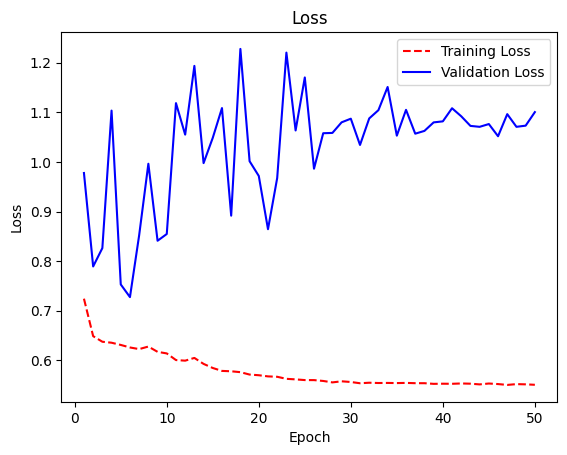

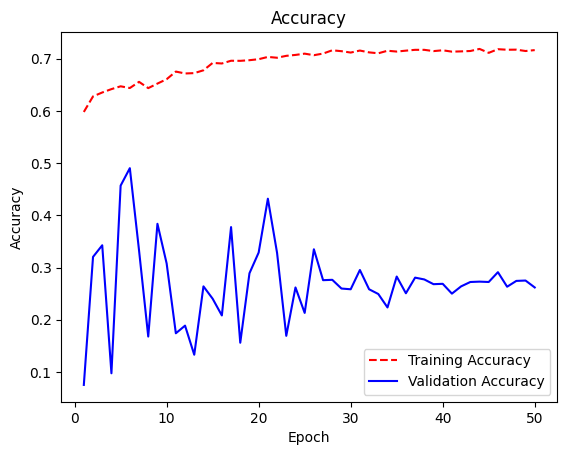

Epoch: 6
loss:0.63
accuracy:0.64
val_loss:0.73
val_accuracy:0.49
lr:0.0


In [ ]:
for key in model_softmax.keys():
  print("_"*10, key, "_"*50)
  model_softmax[key] = Model(model_softmax[key], 0.001, f'/content/drive/MyDrive/final_model/checkpoint_sigmoid/{key}', "binary_crossentropy")
  model_softmax[key].train(model_data[key].images, model_data[key].labels, batch_size=64, epoch=50, validation_split=0.2)
  tf.keras.backend.clear_session()

## Elm Training

In [ ]:
for key in model_softmax.keys():
  for layer in model_softmax[key].model.layers:
      layer.trainable = False
  model_softmax[key].remove_layer(2)

In [ ]:
def batch_predict(model, images, batch=32):
  array1 = []
  for idx in range(0, len(images), batch):
    array2 = model.predict(images[idx: min(len(images), idx+batch)], verbose=0)
    if len(array1)>0:
      array1 = np.concatenate((array1, array2), axis=0)
    else:
      array1 = array2
  return array1

In [ ]:
model_elm = {}
for key in model_softmax.keys():
  print("_"*10, key, "_"*10)
  Xtrain = batch_predict(model_softmax[key].headless_model, model_data[key].images, 64)
  Ytrain = model_data[key].labels

  model_elm[key] = elm(hidden_units=16, activation_function='relu', random_type='normal', x=Xtrain, y=Ytrain, C=0.1, elm_type='clf')
  beta, train_accuracy, running_time = model_elm[key].fit('solution2')
  print("classifier train accuracy:", train_accuracy)
  print('classifier running time:', running_time)

__________ 152_full __________
classifier train accuracy: 0.813039843967679
classifier running time: 0.02625107765197754
__________ 101_full __________
classifier train accuracy: 0.5986347171914183
classifier running time: 0.015297889709472656
__________ 50_full __________
classifier train accuracy: 0.601142379492895
classifier running time: 0.02294445037841797
__________ 152_freeze __________
classifier train accuracy: 0.7938144329896907
classifier running time: 0.022678375244140625
__________ 101_freeze __________
classifier train accuracy: 0.5702145444413486
classifier running time: 0.022247791290283203
__________ 50_freeze __________
classifier train accuracy: 0.6035107272220674
classifier running time: 0.023050546646118164


## Svm Training

In [ ]:
model_svm = {}
for key in model_softmax.keys():
  print("_"*10, key, "_"*10)
  #with tf.device('/CPU:0'):
  Xtrain = batch_predict(model_softmax[key].headless_model, model_data[key].images, 64)
  Ytrain = model_data[key].labels
  model_svm[key] = make_pipeline(SVC())
  model_svm[key].fit(Xtrain, Ytrain)
  print("Classifier train accuracy:", model_svm[key].score(Xtrain, Ytrain))

__________ 152_full __________
Classifier train accuracy: 0.9150181108943996
__________ 101_full __________
Classifier train accuracy: 0.6402897743103929
__________ 50_full __________
Classifier train accuracy: 0.6448871551964336
__________ 152_freeze __________
Classifier train accuracy: 0.9207300083588743
__________ 101_freeze __________
Classifier train accuracy: 0.6167456115909724
__________ 50_freeze __________
Classifier train accuracy: 0.6369462245750905


In [ ]:
#dump training data
training_dataset = None
training_dataset_152_layer = None
model_data = None

## Load Test Data

In [ ]:
# test Data
image_loc_ground = glob.glob(test_gt+"/*.jpg")
label_ground = len(image_loc_ground) * ["ground"]

image_loc_gen = glob.glob(test_gen+"/*.jpg")
label_gen = len(image_loc_gen) * ["recon"]

image_loc_ec = glob.glob(test_ec+"/*.jpg")
label_ec = len(image_loc_ec) * ["recon"]

image_loc_vqvae = glob.glob(test_vqvae+"/*.jpg")
label_vqvae = len(image_loc_vqvae) * ["recon"]

test_dataset = {
    "gen": DatasetCreation(
        image_loc_ground+image_loc_gen,
        label_ground+label_gen,
        "binary"
        ),
    "ec": DatasetCreation(
        image_loc_ground+image_loc_ec,
        label_ground+label_ec,
        "binary"
        ),
    "vqvae": DatasetCreation(
        image_loc_ground+image_loc_vqvae,
        label_ground+label_vqvae,
        "binary"
        ),
}

test_dataset_152_layer = {
    "gen": DatasetCreation(
        image_loc_ground+image_loc_gen,
        label_ground+label_gen,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
    "ec": DatasetCreation(
        image_loc_ground+image_loc_ec,
        label_ground+label_ec,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
    "vqvae": DatasetCreation(
        image_loc_ground+image_loc_vqvae,
        label_ground+label_vqvae,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
}
model_data = {
    "152_full": test_dataset_152_layer,
    "101_full": test_dataset,
    "50_full": test_dataset,
    "152_freeze": test_dataset_152_layer,
    "101_freeze": test_dataset,
    "50_freeze": test_dataset,
}

_________Loading Images__________


100%|██████████| 1000/1000 [00:04<00:00, 201.70it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:04<00:00, 214.05it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:04<00:00, 207.53it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:03<00:00, 272.91it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:03<00:00, 290.79it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:03<00:00, 282.06it/s]


## Testing Resnet



 __________________________________________________ 152_full __________________________________________________

__________gen__________
Accuracy 0.756
Precision: 0.718000
Recall: 0.777056
F1 score: 0.746362
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       500
           1       0.78      0.72      0.75       500

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000



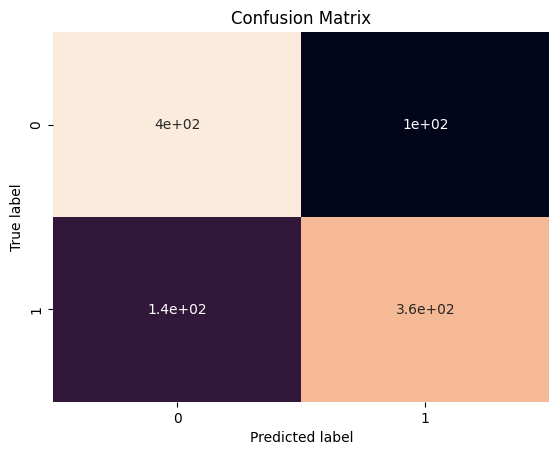

__________ec__________
Accuracy 0.893
Precision: 0.992000
Recall: 0.828047
F1 score: 0.902639
              precision    recall  f1-score   support

           0       0.99      0.79      0.88       500
           1       0.83      0.99      0.90       500

    accuracy                           0.89      1000
   macro avg       0.91      0.89      0.89      1000
weighted avg       0.91      0.89      0.89      1000



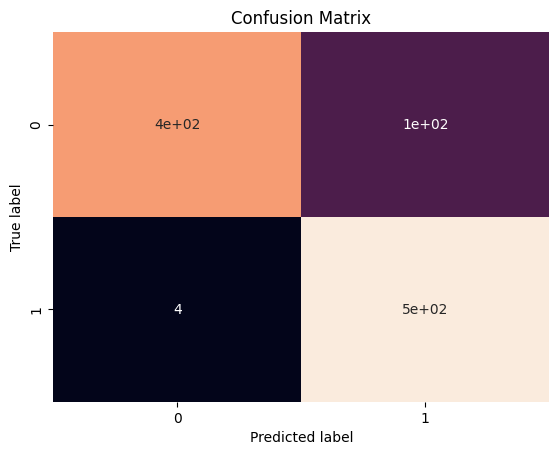

__________vqvae__________
Accuracy 0.875
Precision: 0.956000
Recall: 0.822719
F1 score: 0.884366
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       500
           1       0.82      0.96      0.88       500

    accuracy                           0.88      1000
   macro avg       0.89      0.88      0.87      1000
weighted avg       0.89      0.88      0.87      1000



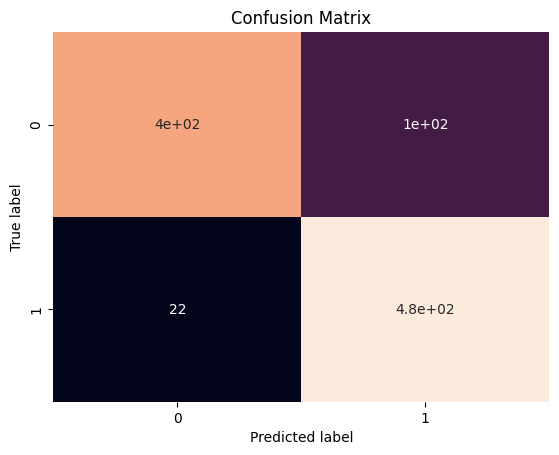



 __________________________________________________ 101_full __________________________________________________

__________gen__________
Accuracy 0.554
Precision: 0.418000
Recall: 0.574176
F1 score: 0.483796
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       500
           1       0.57      0.42      0.48       500

    accuracy                           0.55      1000
   macro avg       0.56      0.55      0.55      1000
weighted avg       0.56      0.55      0.55      1000



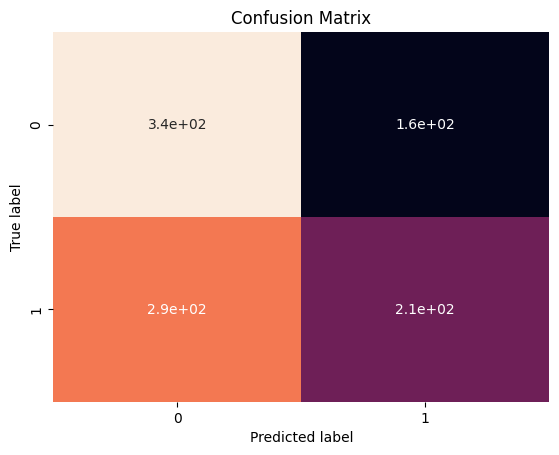

__________ec__________
Accuracy 0.667
Precision: 0.644000
Recall: 0.675052
F1 score: 0.659161
              precision    recall  f1-score   support

           0       0.66      0.69      0.67       500
           1       0.68      0.64      0.66       500

    accuracy                           0.67      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.67      0.67      0.67      1000



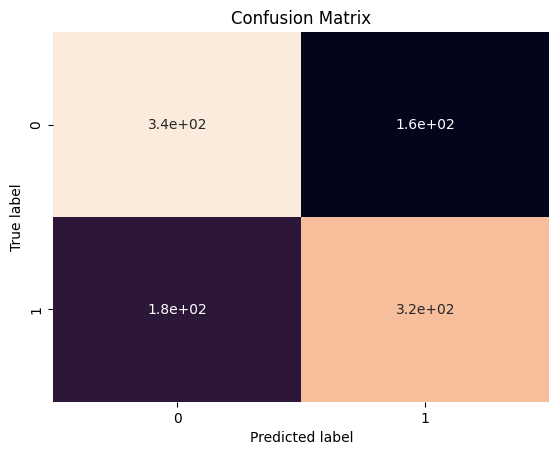

__________vqvae__________
Accuracy 0.524
Precision: 0.358000
Recall: 0.535928
F1 score: 0.429257
              precision    recall  f1-score   support

           0       0.52      0.69      0.59       500
           1       0.54      0.36      0.43       500

    accuracy                           0.52      1000
   macro avg       0.53      0.52      0.51      1000
weighted avg       0.53      0.52      0.51      1000



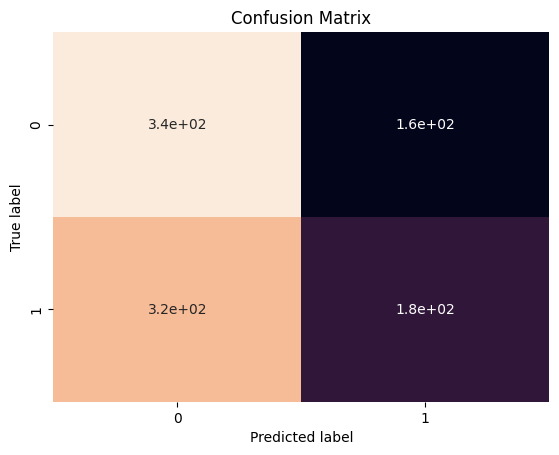



 __________________________________________________ 50_full __________________________________________________

__________gen__________
Accuracy 0.575
Precision: 0.518000
Recall: 0.584650
F1 score: 0.549311
              precision    recall  f1-score   support

           0       0.57      0.63      0.60       500
           1       0.58      0.52      0.55       500

    accuracy                           0.57      1000
   macro avg       0.58      0.57      0.57      1000
weighted avg       0.58      0.57      0.57      1000



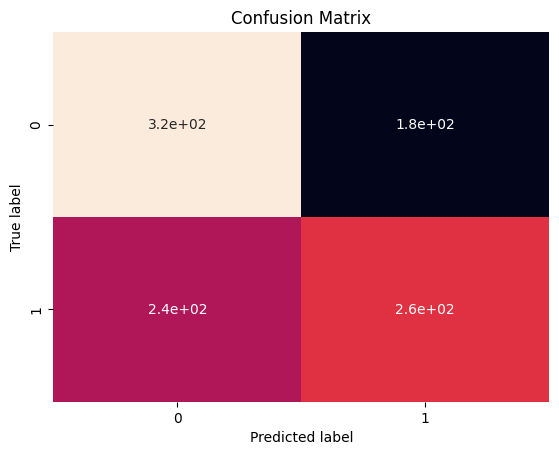

__________ec__________
Accuracy 0.703
Precision: 0.774000
Recall: 0.677758
F1 score: 0.722689
              precision    recall  f1-score   support

           0       0.74      0.63      0.68       500
           1       0.68      0.77      0.72       500

    accuracy                           0.70      1000
   macro avg       0.71      0.70      0.70      1000
weighted avg       0.71      0.70      0.70      1000



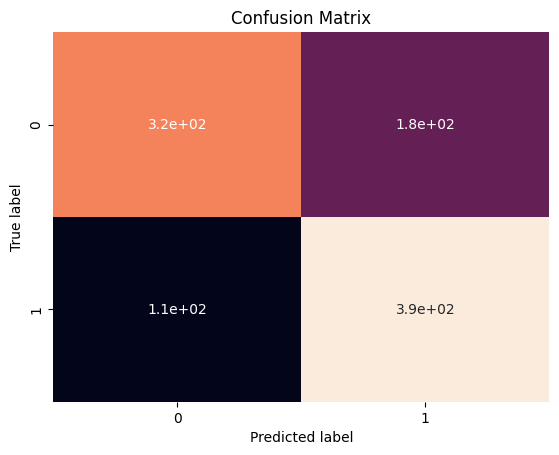

__________vqvae__________
Accuracy 0.558
Precision: 0.484000
Recall: 0.568075
F1 score: 0.522678
              precision    recall  f1-score   support

           0       0.55      0.63      0.59       500
           1       0.57      0.48      0.52       500

    accuracy                           0.56      1000
   macro avg       0.56      0.56      0.56      1000
weighted avg       0.56      0.56      0.56      1000



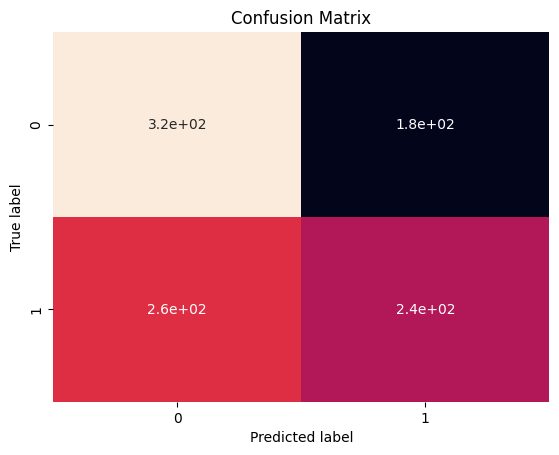



 __________________________________________________ 152_freeze __________________________________________________

__________gen__________
Accuracy 0.758
Precision: 0.686000
Recall: 0.801402
F1 score: 0.739224
              precision    recall  f1-score   support

           0       0.73      0.83      0.77       500
           1       0.80      0.69      0.74       500

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000



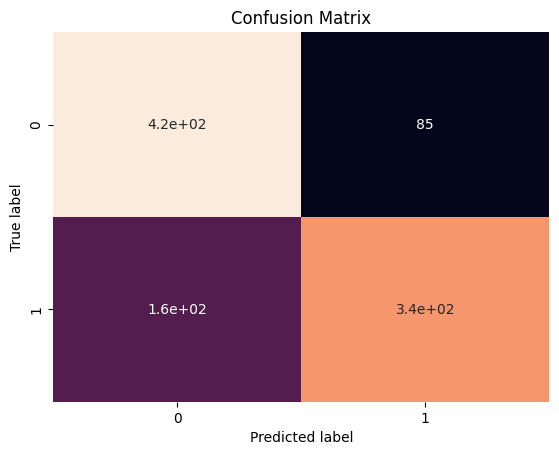

__________ec__________
Accuracy 0.905
Precision: 0.980000
Recall: 0.852174
F1 score: 0.911628
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       500
           1       0.85      0.98      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.90      1000
weighted avg       0.91      0.91      0.90      1000



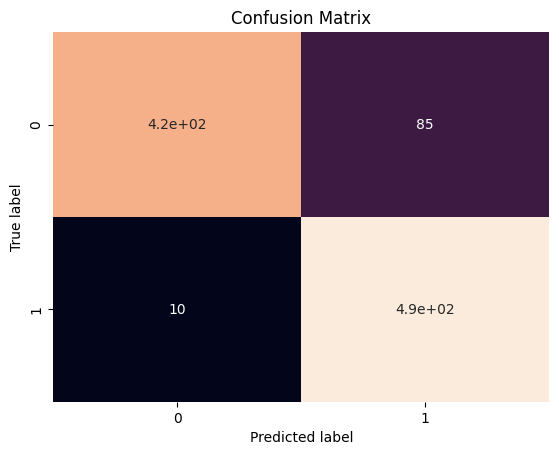

__________vqvae__________
Accuracy 0.89
Precision: 0.950000
Recall: 0.848214
F1 score: 0.896226
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       500
           1       0.85      0.95      0.90       500

    accuracy                           0.89      1000
   macro avg       0.90      0.89      0.89      1000
weighted avg       0.90      0.89      0.89      1000



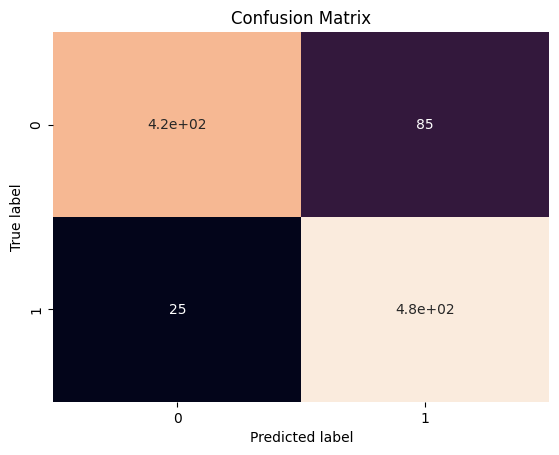



 __________________________________________________ 101_freeze __________________________________________________

__________gen__________
Accuracy 0.555
Precision: 0.446000
Recall: 0.570332
F1 score: 0.500561
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       500
           1       0.57      0.45      0.50       500

    accuracy                           0.56      1000
   macro avg       0.56      0.56      0.55      1000
weighted avg       0.56      0.56      0.55      1000



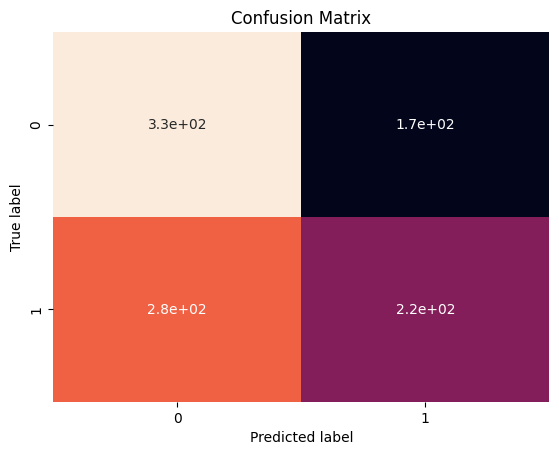

__________ec__________
Accuracy 0.647
Precision: 0.630000
Recall: 0.652174
F1 score: 0.640895
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       500
           1       0.65      0.63      0.64       500

    accuracy                           0.65      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.65      0.65      0.65      1000



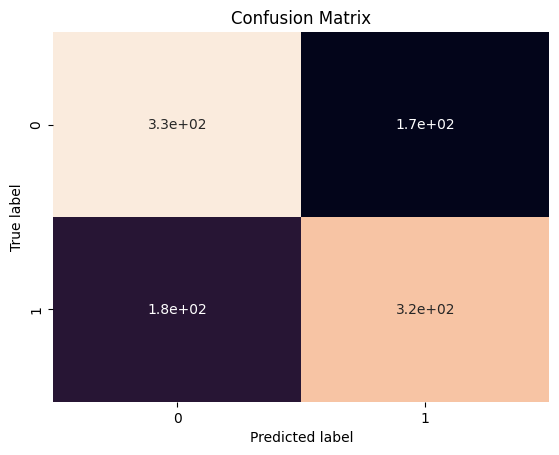

__________vqvae__________
Accuracy 0.521
Precision: 0.378000
Recall: 0.529412
F1 score: 0.441074
              precision    recall  f1-score   support

           0       0.52      0.66      0.58       500
           1       0.53      0.38      0.44       500

    accuracy                           0.52      1000
   macro avg       0.52      0.52      0.51      1000
weighted avg       0.52      0.52      0.51      1000



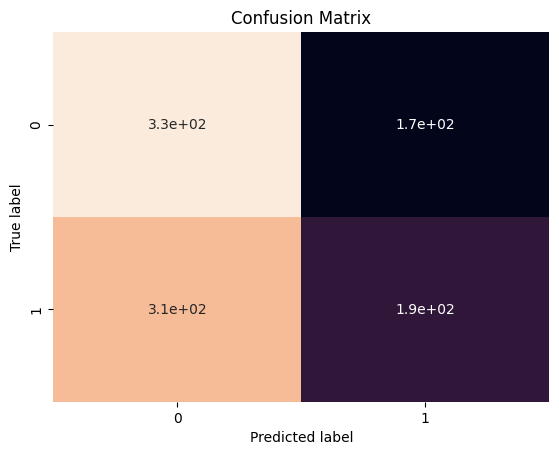



 __________________________________________________ 50_freeze __________________________________________________

__________gen__________
Accuracy 0.57
Precision: 0.458000
Recall: 0.590206
F1 score: 0.515766
              precision    recall  f1-score   support

           0       0.56      0.68      0.61       500
           1       0.59      0.46      0.52       500

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.56      1000
weighted avg       0.57      0.57      0.56      1000



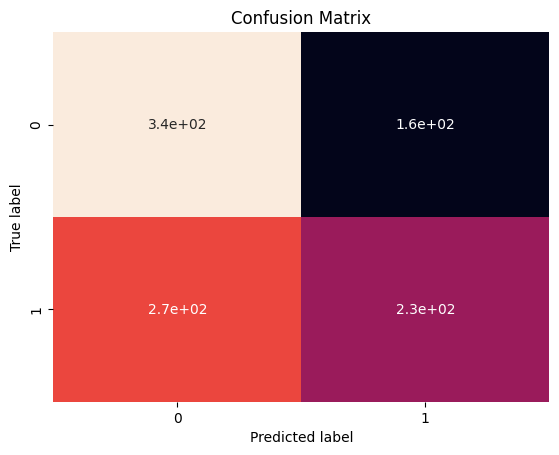

__________ec__________
Accuracy 0.704
Precision: 0.726000
Recall: 0.695402
F1 score: 0.710372
              precision    recall  f1-score   support

           0       0.71      0.68      0.70       500
           1       0.70      0.73      0.71       500

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.70      0.70      0.70      1000



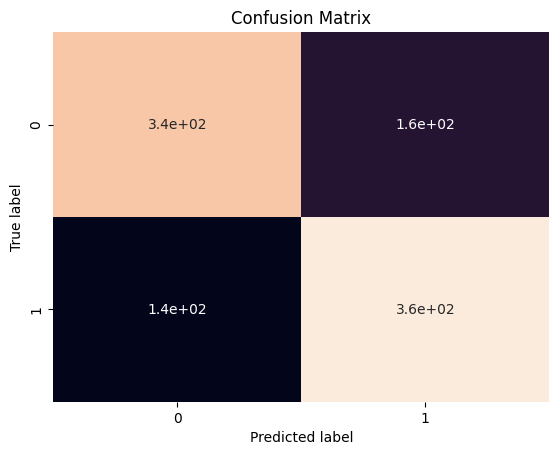

__________vqvae__________
Accuracy 0.559
Precision: 0.436000
Recall: 0.578249
F1 score: 0.497149
              precision    recall  f1-score   support

           0       0.55      0.68      0.61       500
           1       0.58      0.44      0.50       500

    accuracy                           0.56      1000
   macro avg       0.56      0.56      0.55      1000
weighted avg       0.56      0.56      0.55      1000



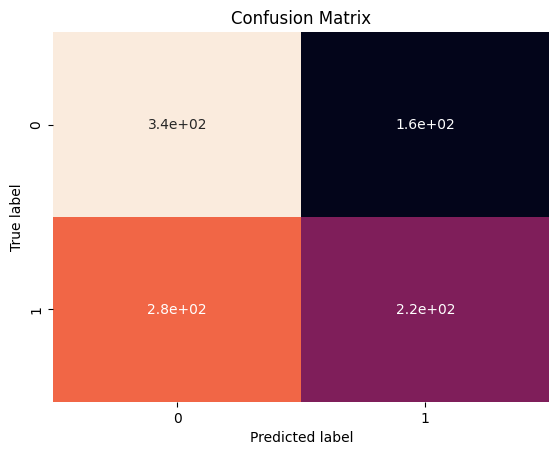

In [ ]:
for model_name in model_softmax.keys():
  print("\n\n","_"*50, model_name, "_"*50, end = "\n\n")

  for key in model_data[model_name].keys():
    y_result = batch_predict(model_softmax[model_name].model, model_data[model_name][key].images, 64)
    y_result = y_result>0.5

    labels = model_data[model_name][key].labels
    print(f"{'_'*10}{key}{'_'*10}")
    print("Accuracy", accuracy_score(y_result, labels))

    # precision tp / (tp + fp)
    precision = precision_score(y_result, labels)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_result, labels)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_result, labels)
    print('F1 score: %f' % f1)

    print(classification_report(labels, y_result))

    cm8 = confusion_matrix(labels, y_result)
    sns.heatmap(cm8, annot=True, cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

## Testing ELM



 __________________________________________________ 152_full __________________________________________________

__________gen__________
Accuracy 0.709
Precision: 0.654000
Recall: 0.734831
F1 score: 0.692063
              precision    recall  f1-score   support

           0       0.69      0.76      0.72       500
           1       0.73      0.65      0.69       500

    accuracy                           0.71      1000
   macro avg       0.71      0.71      0.71      1000
weighted avg       0.71      0.71      0.71      1000



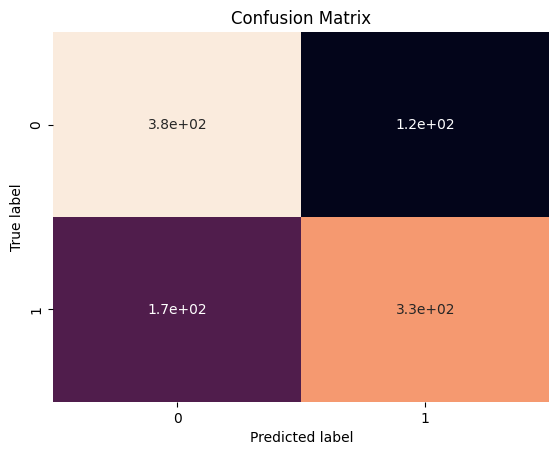

__________ec__________
Accuracy 0.855
Precision: 0.946000
Recall: 0.800338
F1 score: 0.867094
              precision    recall  f1-score   support

           0       0.93      0.76      0.84       500
           1       0.80      0.95      0.87       500

    accuracy                           0.85      1000
   macro avg       0.87      0.85      0.85      1000
weighted avg       0.87      0.85      0.85      1000



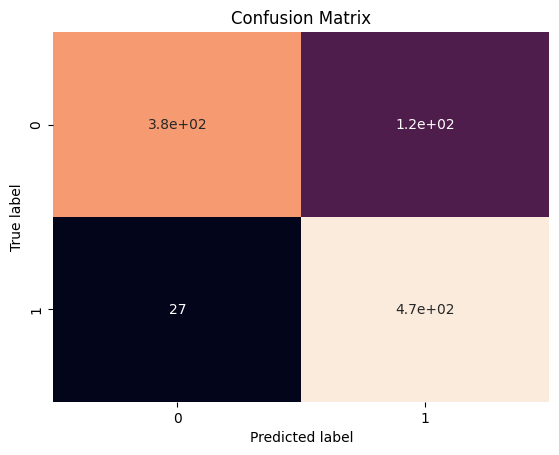

__________vqvae__________
Accuracy 0.835
Precision: 0.906000
Recall: 0.793345
F1 score: 0.845938
              precision    recall  f1-score   support

           0       0.89      0.76      0.82       500
           1       0.79      0.91      0.85       500

    accuracy                           0.83      1000
   macro avg       0.84      0.83      0.83      1000
weighted avg       0.84      0.83      0.83      1000



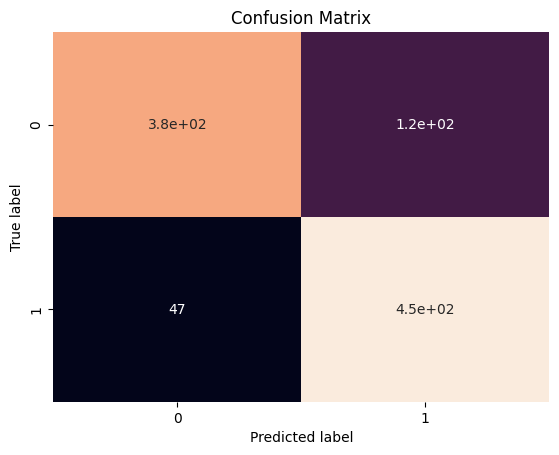



 __________________________________________________ 101_full __________________________________________________

__________gen__________
Accuracy 0.549
Precision: 0.522000
Recall: 0.551797
F1 score: 0.536485
              precision    recall  f1-score   support

           0       0.55      0.58      0.56       500
           1       0.55      0.52      0.54       500

    accuracy                           0.55      1000
   macro avg       0.55      0.55      0.55      1000
weighted avg       0.55      0.55      0.55      1000



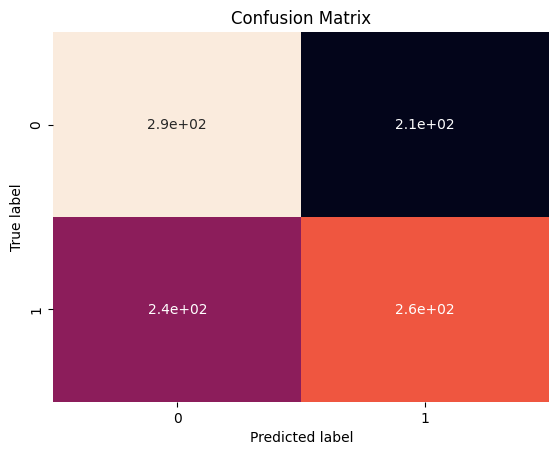

__________ec__________
Accuracy 0.648
Precision: 0.720000
Recall: 0.629371
F1 score: 0.671642
              precision    recall  f1-score   support

           0       0.67      0.58      0.62       500
           1       0.63      0.72      0.67       500

    accuracy                           0.65      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.65      0.65      0.65      1000



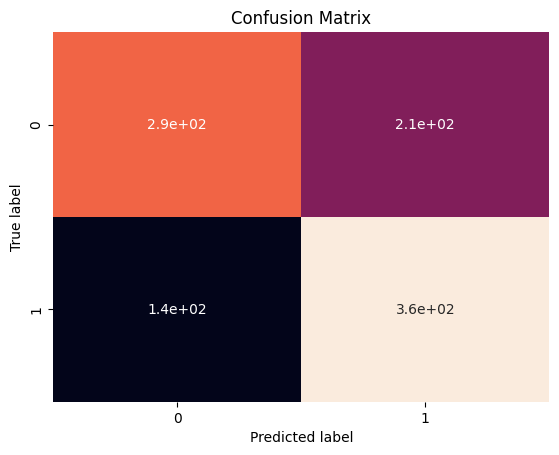

__________vqvae__________
Accuracy 0.546
Precision: 0.516000
Recall: 0.548936
F1 score: 0.531959
              precision    recall  f1-score   support

           0       0.54      0.58      0.56       500
           1       0.55      0.52      0.53       500

    accuracy                           0.55      1000
   macro avg       0.55      0.55      0.55      1000
weighted avg       0.55      0.55      0.55      1000



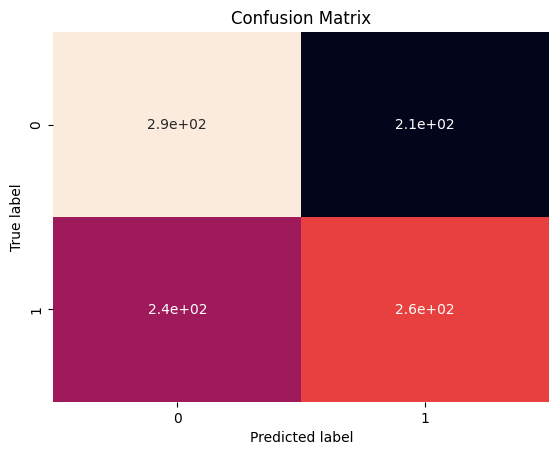



 __________________________________________________ 50_full __________________________________________________

__________gen__________
Accuracy 0.564
Precision: 0.528000
Recall: 0.568966
F1 score: 0.547718
              precision    recall  f1-score   support

           0       0.56      0.60      0.58       500
           1       0.57      0.53      0.55       500

    accuracy                           0.56      1000
   macro avg       0.56      0.56      0.56      1000
weighted avg       0.56      0.56      0.56      1000



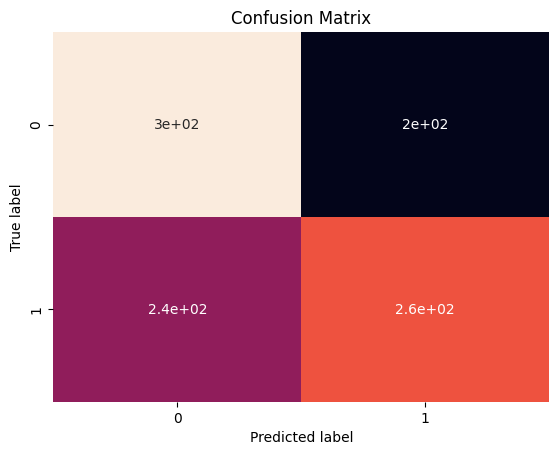

__________ec__________
Accuracy 0.67
Precision: 0.740000
Recall: 0.649123
F1 score: 0.691589
              precision    recall  f1-score   support

           0       0.70      0.60      0.65       500
           1       0.65      0.74      0.69       500

    accuracy                           0.67      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.67      0.67      0.67      1000



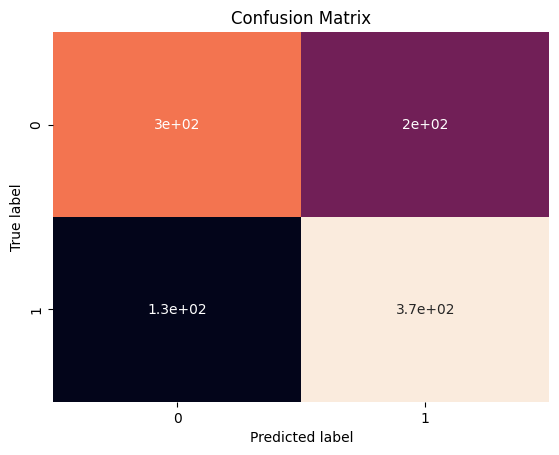

__________vqvae__________
Accuracy 0.551
Precision: 0.502000
Recall: 0.556541
F1 score: 0.527865
              precision    recall  f1-score   support

           0       0.55      0.60      0.57       500
           1       0.56      0.50      0.53       500

    accuracy                           0.55      1000
   macro avg       0.55      0.55      0.55      1000
weighted avg       0.55      0.55      0.55      1000



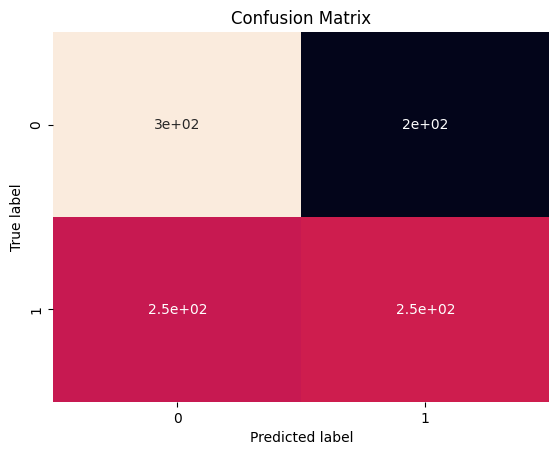



 __________________________________________________ 152_freeze __________________________________________________

__________gen__________
Accuracy 0.683
Precision: 0.580000
Recall: 0.730479
F1 score: 0.646600
              precision    recall  f1-score   support

           0       0.65      0.79      0.71       500
           1       0.73      0.58      0.65       500

    accuracy                           0.68      1000
   macro avg       0.69      0.68      0.68      1000
weighted avg       0.69      0.68      0.68      1000



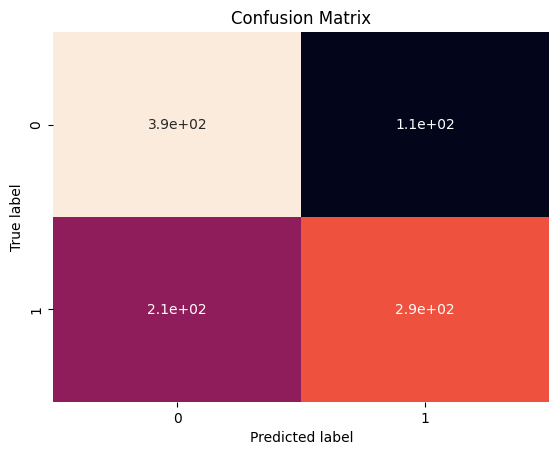

__________ec__________
Accuracy 0.856
Precision: 0.926000
Recall: 0.812281
F1 score: 0.865421
              precision    recall  f1-score   support

           0       0.91      0.79      0.85       500
           1       0.81      0.93      0.87       500

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



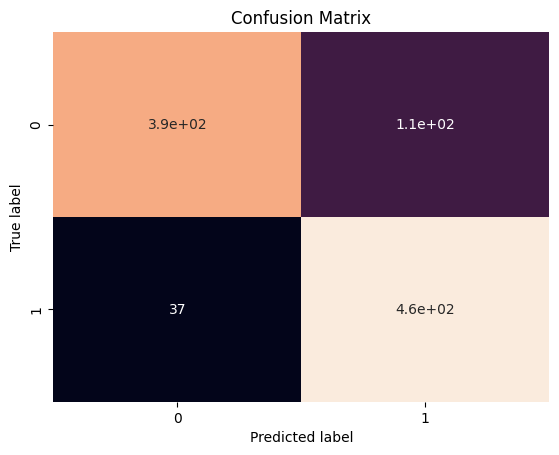

__________vqvae__________
Accuracy 0.826
Precision: 0.866000
Recall: 0.801852
F1 score: 0.832692
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       500
           1       0.80      0.87      0.83       500

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



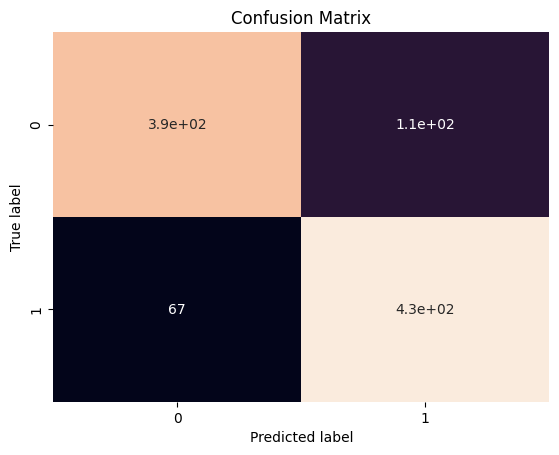



 __________________________________________________ 101_freeze __________________________________________________

__________gen__________
Accuracy 0.533
Precision: 0.584000
Recall: 0.529946
F1 score: 0.555661
              precision    recall  f1-score   support

           0       0.54      0.48      0.51       500
           1       0.53      0.58      0.56       500

    accuracy                           0.53      1000
   macro avg       0.53      0.53      0.53      1000
weighted avg       0.53      0.53      0.53      1000



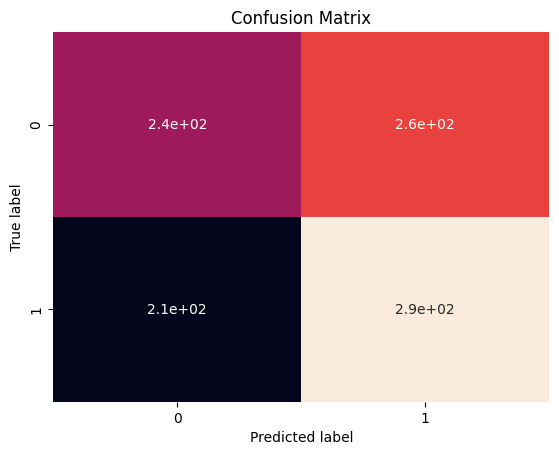

__________ec__________
Accuracy 0.584
Precision: 0.686000
Recall: 0.569767
F1 score: 0.622505
              precision    recall  f1-score   support

           0       0.61      0.48      0.54       500
           1       0.57      0.69      0.62       500

    accuracy                           0.58      1000
   macro avg       0.59      0.58      0.58      1000
weighted avg       0.59      0.58      0.58      1000



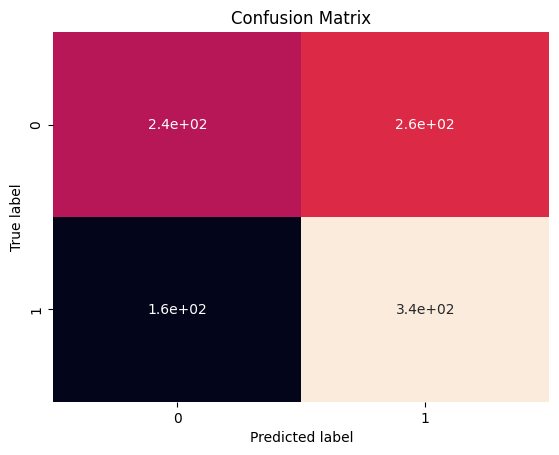

__________vqvae__________
Accuracy 0.522
Precision: 0.562000
Recall: 0.520370
F1 score: 0.540385
              precision    recall  f1-score   support

           0       0.52      0.48      0.50       500
           1       0.52      0.56      0.54       500

    accuracy                           0.52      1000
   macro avg       0.52      0.52      0.52      1000
weighted avg       0.52      0.52      0.52      1000



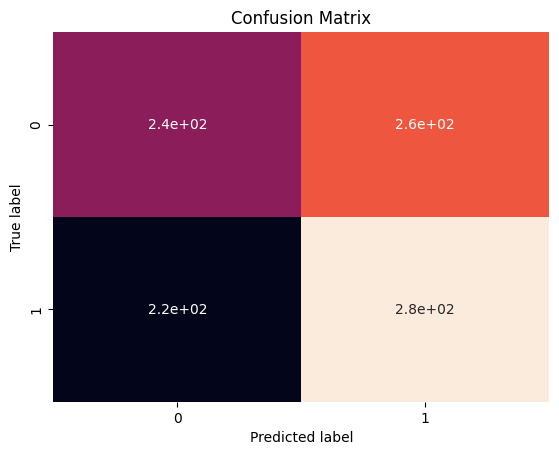



 __________________________________________________ 50_freeze __________________________________________________

__________gen__________
Accuracy 0.552
Precision: 0.450000
Recall: 0.565327
F1 score: 0.501114
              precision    recall  f1-score   support

           0       0.54      0.65      0.59       500
           1       0.57      0.45      0.50       500

    accuracy                           0.55      1000
   macro avg       0.55      0.55      0.55      1000
weighted avg       0.55      0.55      0.55      1000



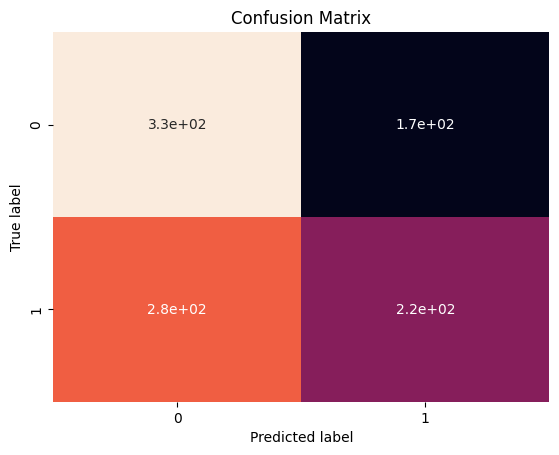

__________ec__________
Accuracy 0.675
Precision: 0.696000
Recall: 0.667946
F1 score: 0.681685
              precision    recall  f1-score   support

           0       0.68      0.65      0.67       500
           1       0.67      0.70      0.68       500

    accuracy                           0.68      1000
   macro avg       0.68      0.68      0.67      1000
weighted avg       0.68      0.68      0.67      1000



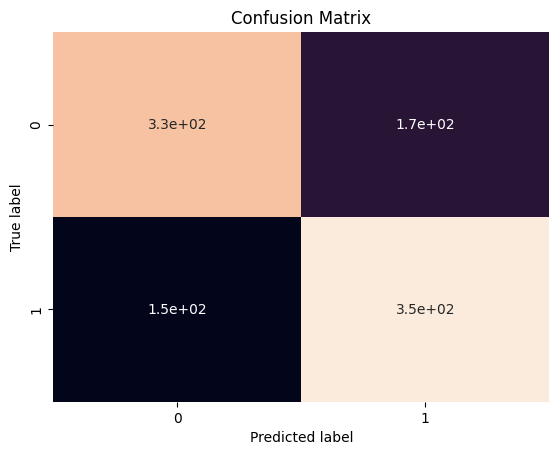

__________vqvae__________
Accuracy 0.546
Precision: 0.438000
Recall: 0.558673
F1 score: 0.491031
              precision    recall  f1-score   support

           0       0.54      0.65      0.59       500
           1       0.56      0.44      0.49       500

    accuracy                           0.55      1000
   macro avg       0.55      0.55      0.54      1000
weighted avg       0.55      0.55      0.54      1000



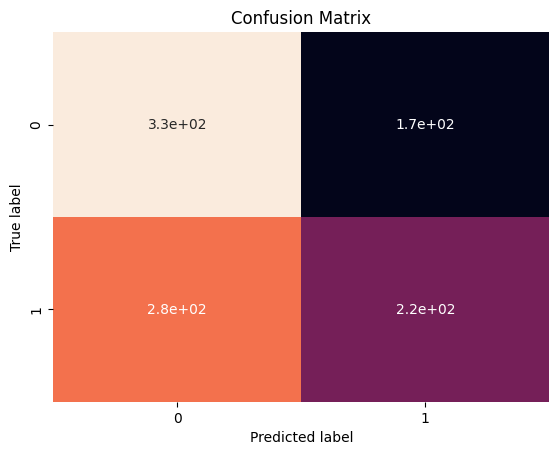

In [ ]:
for model_name in model_softmax.keys():
  print("\n\n","_"*50, model_name, "_"*50, end = "\n\n")

  for key in model_data[model_name].keys():
    Xtest = batch_predict(model_softmax[model_name].headless_model, model_data[model_name][key].images, 64)
    y_result = model_elm[model_name].predict(Xtest)

    labels = model_data[model_name][key].labels
    print(f"{'_'*10}{key}{'_'*10}")
    print("Accuracy", accuracy_score(y_result, labels))

    # precision tp / (tp + fp)
    precision = precision_score(y_result, labels)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_result, labels)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_result, labels)
    print('F1 score: %f' % f1)

    print(classification_report(labels, y_result))

    cm8 = confusion_matrix(labels, y_result)
    sns.heatmap(cm8, annot=True, cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

## Testing SVM



 __________________________________________________ 152_full __________________________________________________

__________gen__________
Accuracy 0.758
Precision: 0.686000
Recall: 0.801402
F1 score: 0.739224
              precision    recall  f1-score   support

           0       0.73      0.83      0.77       500
           1       0.80      0.69      0.74       500

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000



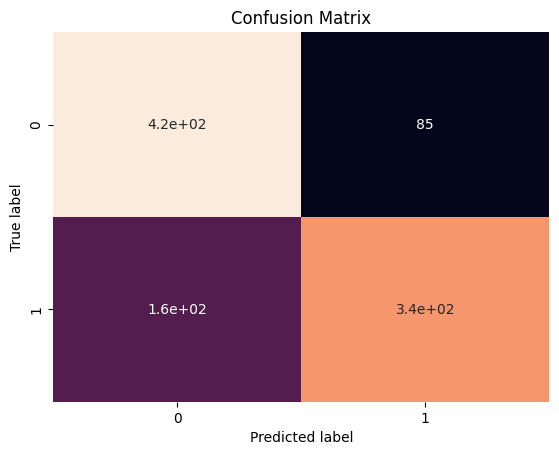

__________ec__________
Accuracy 0.909
Precision: 0.988000
Recall: 0.853195
F1 score: 0.915663
              precision    recall  f1-score   support

           0       0.99      0.83      0.90       500
           1       0.85      0.99      0.92       500

    accuracy                           0.91      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.91      0.91      1000



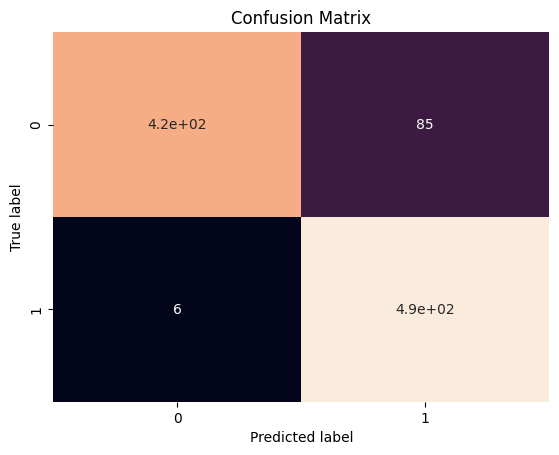

__________vqvae__________
Accuracy 0.889
Precision: 0.948000
Recall: 0.847943
F1 score: 0.895184
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       500
           1       0.85      0.95      0.90       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



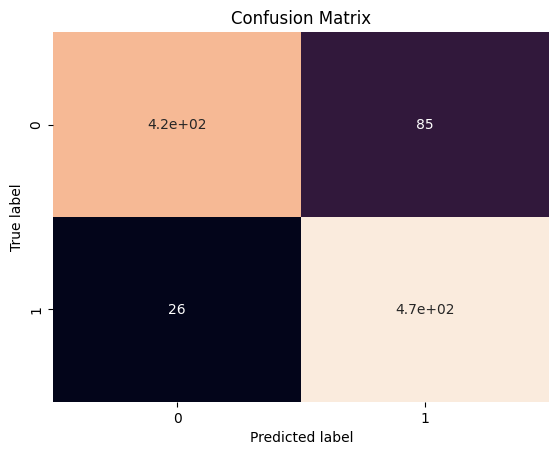



 __________________________________________________ 101_full __________________________________________________

__________gen__________
Accuracy 0.572
Precision: 0.544000
Recall: 0.576271
F1 score: 0.559671
              precision    recall  f1-score   support

           0       0.57      0.60      0.58       500
           1       0.58      0.54      0.56       500

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.57      0.57      0.57      1000



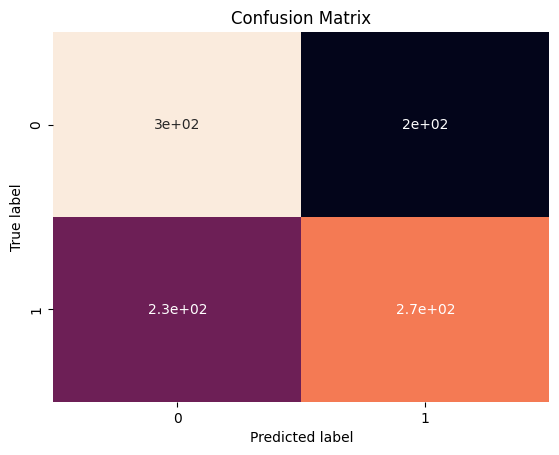

__________ec__________
Accuracy 0.697
Precision: 0.794000
Recall: 0.664992
F1 score: 0.723792
              precision    recall  f1-score   support

           0       0.74      0.60      0.66       500
           1       0.66      0.79      0.72       500

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.69      1000
weighted avg       0.70      0.70      0.69      1000



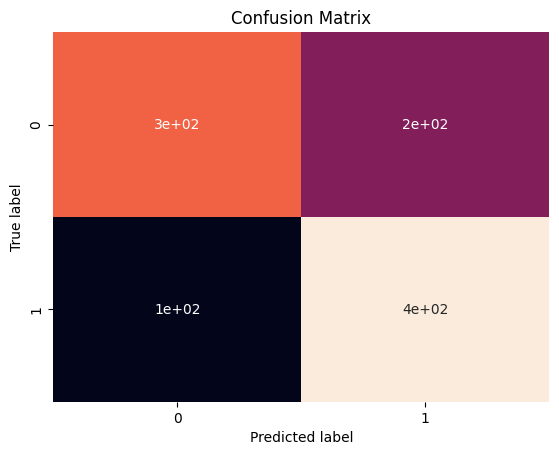

__________vqvae__________
Accuracy 0.546
Precision: 0.492000
Recall: 0.551570
F1 score: 0.520085
              precision    recall  f1-score   support

           0       0.54      0.60      0.57       500
           1       0.55      0.49      0.52       500

    accuracy                           0.55      1000
   macro avg       0.55      0.55      0.54      1000
weighted avg       0.55      0.55      0.54      1000



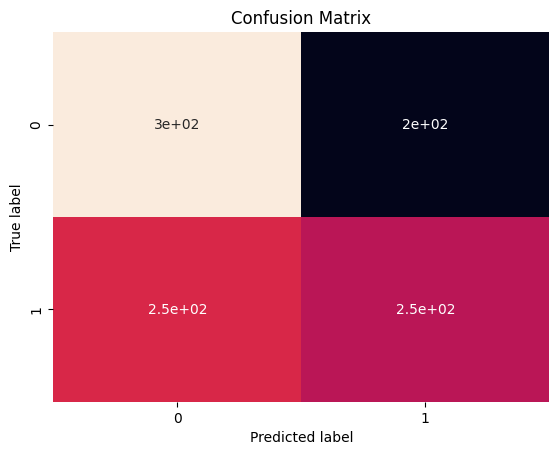



 __________________________________________________ 50_full __________________________________________________

__________gen__________
Accuracy 0.593
Precision: 0.520000
Recall: 0.608899
F1 score: 0.560949
              precision    recall  f1-score   support

           0       0.58      0.67      0.62       500
           1       0.61      0.52      0.56       500

    accuracy                           0.59      1000
   macro avg       0.60      0.59      0.59      1000
weighted avg       0.60      0.59      0.59      1000



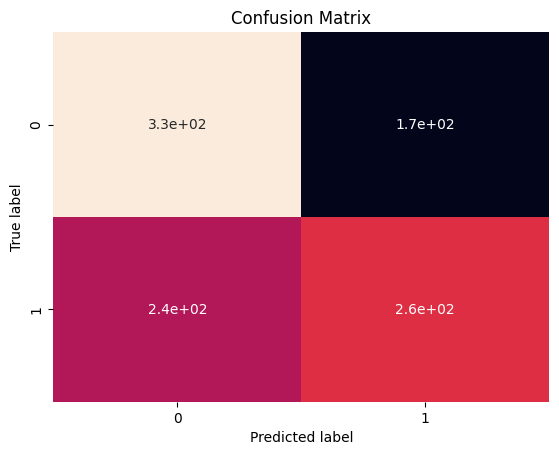

__________ec__________
Accuracy 0.729
Precision: 0.792000
Recall: 0.703375
F1 score: 0.745061
              precision    recall  f1-score   support

           0       0.76      0.67      0.71       500
           1       0.70      0.79      0.75       500

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000



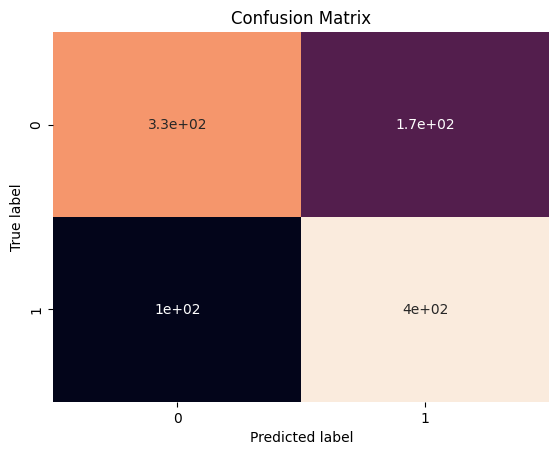

__________vqvae__________
Accuracy 0.574
Precision: 0.482000
Recall: 0.590686
F1 score: 0.530837
              precision    recall  f1-score   support

           0       0.56      0.67      0.61       500
           1       0.59      0.48      0.53       500

    accuracy                           0.57      1000
   macro avg       0.58      0.57      0.57      1000
weighted avg       0.58      0.57      0.57      1000



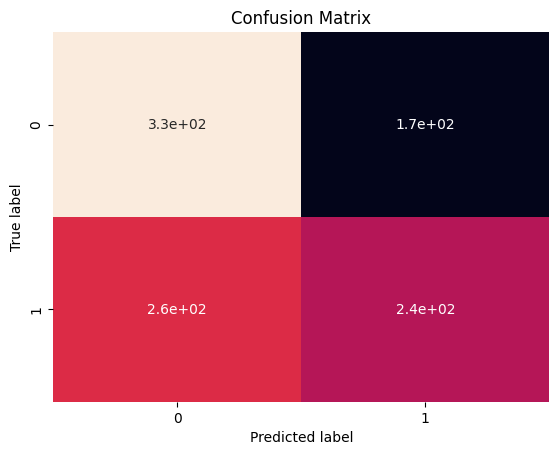



 __________________________________________________ 152_freeze __________________________________________________

__________gen__________
Accuracy 0.772
Precision: 0.714000
Recall: 0.807692
F1 score: 0.757962
              precision    recall  f1-score   support

           0       0.74      0.83      0.78       500
           1       0.81      0.71      0.76       500

    accuracy                           0.77      1000
   macro avg       0.78      0.77      0.77      1000
weighted avg       0.78      0.77      0.77      1000



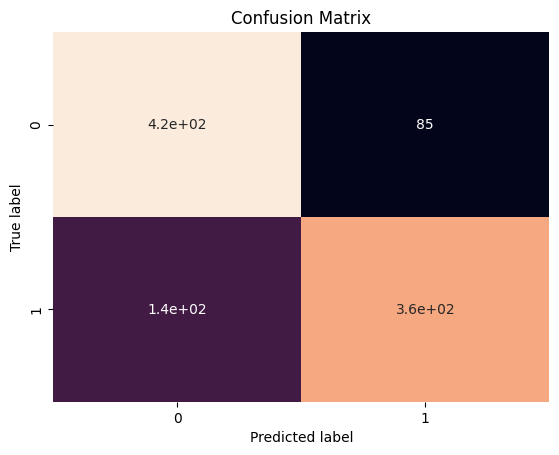

__________ec__________
Accuracy 0.906
Precision: 0.982000
Recall: 0.852431
F1 score: 0.912639
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       500
           1       0.85      0.98      0.91       500

    accuracy                           0.91      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.91      0.91      1000



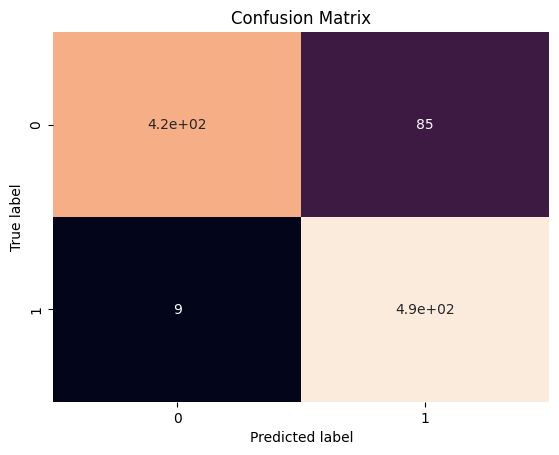

__________vqvae__________
Accuracy 0.89
Precision: 0.950000
Recall: 0.848214
F1 score: 0.896226
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       500
           1       0.85      0.95      0.90       500

    accuracy                           0.89      1000
   macro avg       0.90      0.89      0.89      1000
weighted avg       0.90      0.89      0.89      1000



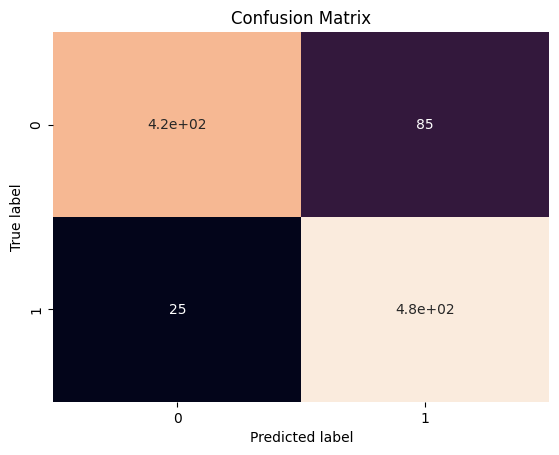



 __________________________________________________ 101_freeze __________________________________________________

__________gen__________
Accuracy 0.572
Precision: 0.590000
Recall: 0.569498
F1 score: 0.579568
              precision    recall  f1-score   support

           0       0.57      0.55      0.56       500
           1       0.57      0.59      0.58       500

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.57      0.57      0.57      1000



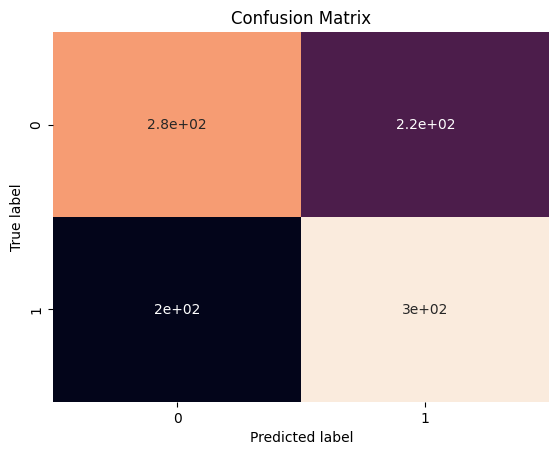

__________ec__________
Accuracy 0.681
Precision: 0.808000
Recall: 0.644338
F1 score: 0.716948
              precision    recall  f1-score   support

           0       0.74      0.55      0.63       500
           1       0.64      0.81      0.72       500

    accuracy                           0.68      1000
   macro avg       0.69      0.68      0.68      1000
weighted avg       0.69      0.68      0.68      1000



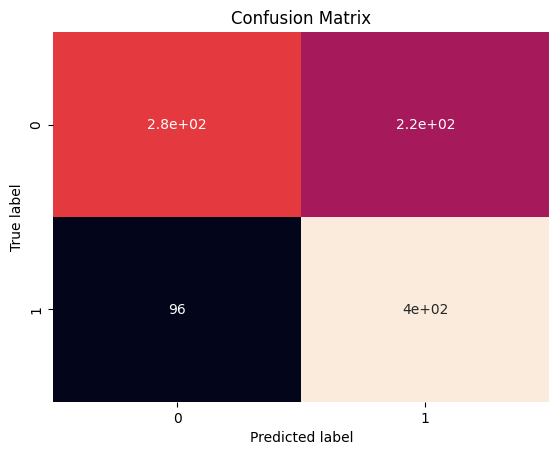

__________vqvae__________
Accuracy 0.537
Precision: 0.520000
Recall: 0.538302
F1 score: 0.528993
              precision    recall  f1-score   support

           0       0.54      0.55      0.54       500
           1       0.54      0.52      0.53       500

    accuracy                           0.54      1000
   macro avg       0.54      0.54      0.54      1000
weighted avg       0.54      0.54      0.54      1000



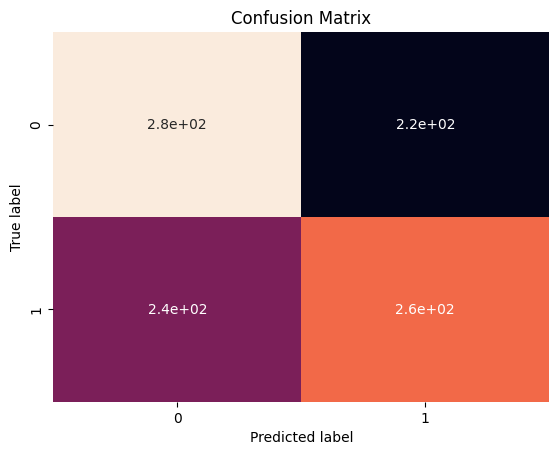



 __________________________________________________ 50_freeze __________________________________________________

__________gen__________
Accuracy 0.582
Precision: 0.514000
Recall: 0.594907
F1 score: 0.551502
              precision    recall  f1-score   support

           0       0.57      0.65      0.61       500
           1       0.59      0.51      0.55       500

    accuracy                           0.58      1000
   macro avg       0.58      0.58      0.58      1000
weighted avg       0.58      0.58      0.58      1000



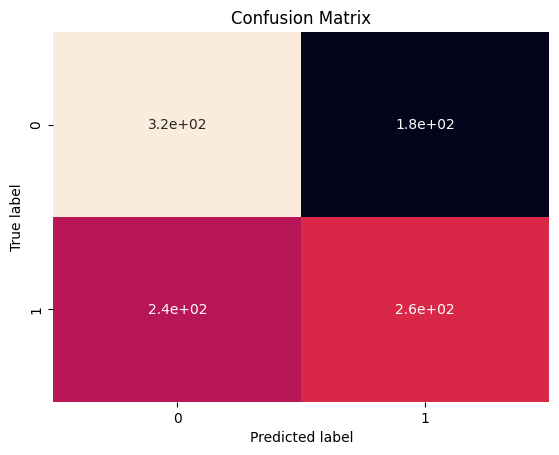

__________ec__________
Accuracy 0.716
Precision: 0.782000
Recall: 0.690813
F1 score: 0.733583
              precision    recall  f1-score   support

           0       0.75      0.65      0.70       500
           1       0.69      0.78      0.73       500

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.71      1000
weighted avg       0.72      0.72      0.71      1000



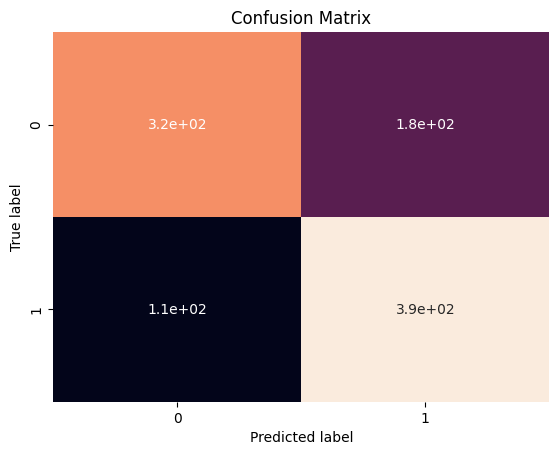

__________vqvae__________
Accuracy 0.565
Precision: 0.480000
Recall: 0.578313
F1 score: 0.524590
              precision    recall  f1-score   support

           0       0.56      0.65      0.60       500
           1       0.58      0.48      0.52       500

    accuracy                           0.56      1000
   macro avg       0.57      0.56      0.56      1000
weighted avg       0.57      0.56      0.56      1000



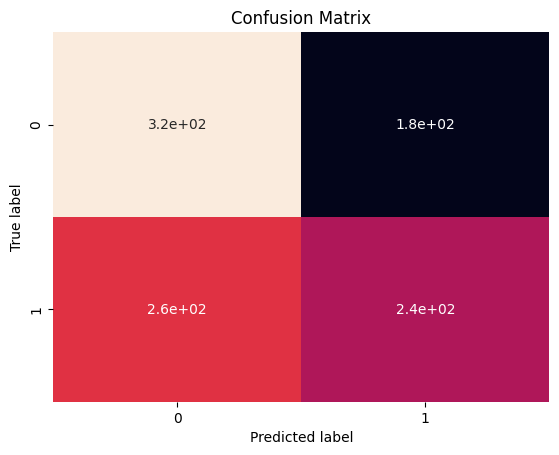

In [36]:
for model_name in model_softmax.keys():
  print("\n\n","_"*50, model_name, "_"*50, end = "\n\n")

  for key in model_data[model_name].keys():
    Xtest = batch_predict(model_softmax[model_name].headless_model, model_data[model_name][key].images, 64)
    y_result = model_svm[model_name].predict(Xtest)

    labels = model_data[model_name][key].labels
    print(f"{'_'*10}{key}{'_'*10}")
    print("Accuracy", accuracy_score(y_result, labels))

    # precision tp / (tp + fp)
    precision = precision_score(y_result, labels)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_result, labels)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_result, labels)
    print('F1 score: %f' % f1)

    print(classification_report(labels, y_result))

    cm8 = confusion_matrix(labels, y_result)
    sns.heatmap(cm8, annot=True, cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()